In [1]:
import pandas as pd

In [35]:
# Read the data xlsx
df_20_a = pd.read_csv('data/stop_level/stop2020_1to6.csv')
df_20_b = pd.read_csv('data/stop_level/stop2020_7to11.csv')
df_20_c = pd.read_csv('data/stop_level/stop2020_11to2021_1.csv')
df_21_a = pd.read_csv('data/stop_level/stop2021_2to2021_4.csv')
df_21_b = pd.read_csv('data/stop_level/stop2021_5to2021_7.csv')
df_21_c = pd.read_csv('data/stop_level/stop2021_8to2021_10.csv')
df_21_d = pd.read_csv('data/stop_level/stop2021_11to2021_12.csv')
df_22_a = pd.read_csv('data/stop_level/stop2022_1to2022_2.csv')
df_22_b = pd.read_csv('data/stop_level/stop2022_3to2022_5.csv')
df_22_c = pd.read_csv('data/stop_level/stop2022_6to2022_8.csv')
df_22_d = pd.read_csv('data/stop_level/stop2022_7to2022_9.csv')
df_22_d = df_22_d[df_22_d['OPD_DATE'] >= '2022-09-01']
df_22_e = pd.read_csv('data/stop_level/stop2022_10to2022_12.csv')

In [36]:
# Vertically concatenate the dataframes, drop duplicates based on OPD_DATE
df = pd.concat([df_20_a, df_20_b, df_20_c, df_21_a, df_21_b, df_21_c, df_21_d, df_22_a, df_22_b, df_22_c, df_22_d, df_22_e], axis=0, ignore_index=True)

In [37]:
df

,Unnamed: 0,OPD_DATE,STOP_ID,TOTAL_BOARDING,TOTAL_ALIGHTING,datenew,weekday,month
0,1,01-JAN-20,258,1,0,2020-01-01,Wednesday,1
1,2,01-JAN-20,280,42,3,2020-01-01,Wednesday,1
2,3,01-JAN-20,320,102,2,2020-01-01,Wednesday,1
3,4,01-JAN-20,340,98,41,2020-01-01,Wednesday,1
4,5,01-JAN-20,360,49,0,2020-01-01,Wednesday,1
...,...,...,...,...,...,...,...,...
5997244,509577,2022-12-31,99756,0,0,2022-12-31,Saturday,12
5997245,509578,2022-12-31,99760,0,0,2022-12-31,Saturday,12
5997246,509579,2022-12-31,99804,7,0,2022-12-31,Saturday,12
5997247,509580,2022-12-31,99811,15,2,2022-12-31,Saturday,12


In [3]:
# Read census data
df_census = pd.read_excel('data/stop_level/stops_census_info.xlsx')

# Check df_census for number of duplicates
print(df_census.duplicated().sum())

# Drop duplicates
df_census = df_census.drop_duplicates()

29298


In [5]:
# Merge based on 'STOP_ID'
df_merged = pd.merge(df, df_census, on='STOP_ID')

df_merged = df_merged[['OPD_DATE', 'STOP_ID', 'TOTAL_BOARDING', 'TOTAL_ALIGHTING', 'weekday', 'month', 'geometry', 'NAME', 'GEOID']]

df_merged.head()

,OPD_DATE,STOP_ID,TOTAL_BOARDING,TOTAL_ALIGHTING,weekday,month,geometry,NAME,GEOID
0,2020-01-01,258,1,0,Wednesday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002
1,2020-01-02,258,17,2,Thursday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002
2,2020-01-03,258,17,0,Friday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002
3,2020-01-04,258,0,0,Saturday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002
4,2020-01-05,258,0,0,Sunday,1,"c(-122.342984416285, 47.6125715497749)",80.02,53033008002


In [9]:
# See the number of unique GEOIDs
print(df_merged['GEOID'].nunique())

# Create new GEOID column that spans from 1 to 457
df_merged['GEOID_cat'] = df_merged['GEOID'].astype('category')

df_merged['GEOID_cat']

457


0          53033008002
1          53033008002
2          53033008002
3          53033008002
4          53033008002
              ...     
1055993    53033009900
1055994    53033009900
1055995    53033009900
1055996    53033009900
1055997    53033009900
Name: GEOID_cat, Length: 1055998, dtype: category
Categories (457, int64): [53033000101, 53033000102, 53033000201, 53033000202, ..., 53061051100, 53061051302, 53061051916, 53061051938]

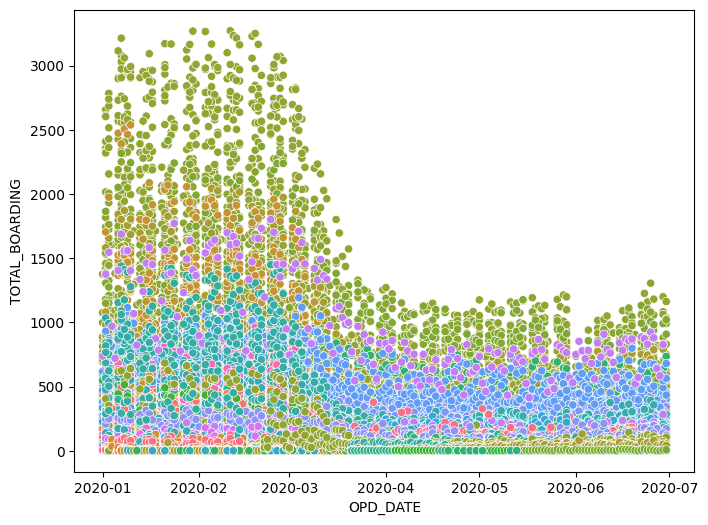

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Groupby GEOID, scatter plot boardings over time for each census tract on the same plot
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='OPD_DATE', y='TOTAL_BOARDING', hue='GEOID_cat', data=df_merged, legend=False, ax=ax)
plt.show()